# Import librairies

In [52]:
# Import necessary libraries and modules
import csv
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import shap
import tensorflow as tf
from tensorflow import keras
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download("stopwords")

# Import additional libraries and modules that require a progress bar
from random import randint
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /Users/omar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Training and validation set

In [ ]:
# Create a graph
G = nx.read_edgelist('edgelist.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)

Number of nodes: 138499
Number of edges: 1091955


In [204]:
def extract_test_edges(G, split_rate):
    """
    Randomly select a portion of the edges from the graph G, remove them from G,
    and create a validation dataset with an equal number of positive and negative samples.

    Args:
        G (networkx.Graph): The input graph.
        split_rate (float): The proportion of edges to be removed for validation.

    Returns:
        G (networkx.Graph): The modified graph with selected edges removed.
        val_edges (list): A list of validation edges (positive and negative samples).
        y_val (list): The corresponding labels for the validation edges (1 for positive samples, 0 for negative samples).
    """
    val_edges = list()
    y_val = list()
    edges = G.edges()
    nodes = list(G.nodes())
    n = G.number_of_nodes()

    # Select edges randomly based on split_rate and add them to val_edges
    for edge in edges:
        if random.random() < split_rate:
            val_edges.append(edge)
            y_val.append(1)

    # Generate negative samples and add them to the list
    negative_samples = list()
    for i in range(len(val_edges)):
        n1 = nodes[randint(0, n - 1)]
        n2 = nodes[randint(0, n - 1)]
        negative_samples.append((n1, n2))
        y_val.append(0)

    # Remove selected edges from the graph G
    for edge in val_edges:
        G.remove_edge(edge[0], edge[1])

    # Combine positive and negative samples in val_edges
    val_edges = [*val_edges, *negative_samples]

    return G, val_edges, y_val


# Usage:
G, val_edges, y_valid = extract_test_edges(G, 0.2)

In [245]:
# Convert the validation labels to a NumPy array
y_valid = np.array(y_valid)

# Features engineering

In [ ]:
def get_jaccard_coefficient(current_node1, current_node2):
    """Calculate the Jaccard Coefficient for two nodes."""
    jac = nx.jaccard_coefficient(G, [(current_node1, current_node2)])
    return list(jac)[-1][-1]


def get_adamic_adar_index(e1, e2):
    """Calculate the Adamic-Adar Index for two nodes."""
    preds = nx.adamic_adar_index(G, [(e1, e2)])
    try:
        for u, v, p in preds:
            return p
    except:
        return 0


def get_clustering(e1, e2):
    """Calculate the clustering coefficient for two nodes."""
    res = list(nx.clustering(G, [e1, e2]).values())
    if len(res) == 1:
        res = [res[0], res[0]]
    return res


def get_common_neighbor_centrality(e1, e2):
    """Calculate the Common Neighbor Centrality for two nodes."""
    preds = nx.common_neighbor_centrality(G, [(e1, e2)])
    for u, v, p in preds:
        return p


def get_cn_soundarajan_hopcroft(e1, e2):
    """Calculate the CN Soundarajan-Hopcroft score for two nodes."""
    preds = nx.cn_soundarajan_hopcroft(G, [(e1, e2)])
    try:
        for u, v, p in preds:
            return p
    except:
        return 0


def get_ra_index_soundarajan_hopcroft(e1, e2):
    """Calculate the RA Soundarajan-Hopcroft score for two nodes."""
    preds = nx.ra_index_soundarajan_hopcroft(G, [(e1, e2)])
    try:
        for u, v, p in preds:
            return p
    except:
        return 0


def get_degree(node):
    """Calculate the degree of a node."""
    res = G.degree(node)
    return res


def get_degree_centrality(node):
    """Calculate the degree centrality of a node."""
    res = nx.degree_centrality(G)[0]
    return res


def get_resource_allocation(e1, e2):
    """Calculate the Resource Allocation Index for two nodes."""
    preds = nx.resource_allocation_index(G, [(e1, e2)])
    for u, v, p in preds:
        return p


def get_abstract_embedding(node):
    """Get the abstract embedding of a node."""
    res = abstracts_emb[node]
    return res


def get_authors_embedding(node):
    """Get the authors embedding of a node."""
    res = authors_emb[node]
    return res


def get_cosine_similarity(list_1, list_2):
    """Calculate the cosine similarity between two vectors."""
    cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
    return cos_sim

## Abstract embeddings

In [345]:
# Load abstracts from a file and preprocess them
abstracts = dict()
abstracts_split_list = []
stop = set(stopwords.words("english"))

# Read abstracts from file and tokenize them
with open('abstracts.txt', 'r') as f:
    for line in tqdm(f, total=138499):
        node, abstract = line.split('|--|')
        abstracts_split = [word.lower() for word in abstract.split() if word.lower() not in stop]
        abstracts_split_list.append(abstracts_split)

# Train a Doc2Vec model on the preprocessed abstracts
print("tagging documents")
documents = [TaggedDocument(doc, [i]) for i, doc in tqdm(enumerate(abstracts_split_list), total=len(abstracts_split_list))]

print("begin training")
doc2vec_model_abstracts = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=8)

100%|██████████| 138499/138499 [00:05<00:00, 25819.80it/s]


tagging documents


100%|██████████| 138499/138499 [00:29<00:00, 4693.64it/s] 


begin training


In [365]:
# save doc2vec model
#Doc2Vec.save(doc2vec_model_abstracts, "doc2vec_model_abstracts")
# load
#doc2vec_model_abstratcs = Doc2Vec.load("doc2vec_model_abstracts")

In [358]:
# Load abstracts from a file, preprocess them and get embeddings using the trained Doc2Vec model
abstracts_ = dict()

# Read abstracts from file and tokenize them
with open('abstracts.txt', 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts_[int(node)] = [word.lower() for word in abstract.split() if word.lower() not in stop]

# Get embeddings for each node in the graph using the trained Doc2Vec model
abstracts_emb = {}
for i, node in tqdm(enumerate(G.nodes()), total=len(G.nodes())):
    doc = abstracts_[node]
    node_emb = doc2vec_model_abstracts.dv[node]
    abstracts_emb[node] = node_emb

100%|██████████| 138499/138499 [00:00<00:00, 324308.14it/s]


## Authors embeddings

In [364]:
# Load authors from a file, preprocess them and train a Doc2Vec model
authors = dict()

# Read authors from file and store them in a dictionary
with open('authors.txt', 'r') as f:
    for line in f:
        node, author = line.split('|--|')
        authors[int(node)] = author

# Map text to set of terms
for node in authors:
    authors[node] = authors[node].strip().split(sep=", ")

# Create TaggedDocument objects for each set of authors
documents = [TaggedDocument(doc, [i]) for i, doc in tqdm(enumerate(authors.values()), total=len(authors))]

# Train a Doc2Vec model on the preprocessed authors
print("training")
doc2vec_model_authors = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=8)

100%|██████████| 138499/138499 [00:00<00:00, 1103234.29it/s]


training


In [366]:
# save doc2vec model
Doc2Vec.save(doc2vec_model_authors, "doc2vec_model_authors")

In [370]:
# Get embeddings for each node in the graph using the trained Doc2Vec model for authors
authors_emb = {}
for i, node in tqdm(enumerate(G.nodes()), total=len(G.nodes())):
    doc = authors[node]
    node_emb = doc2vec_model_authors.dv[node]
    authors_emb[node] = node_emb

100%|██████████| 138499/138499 [00:00<00:00, 486372.61it/s]


## Building features on X_train, y_train,  X_test

In [386]:
# Reload the abstracts of each paper and map the text to a set of terms
abstracts = dict()

# Read abstracts from the file
with open('abstracts.txt', 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Map text to set of terms
for node in abstracts:
    abstracts[node] = set(abstracts[node].split())

In [387]:
# Create training set with feature vectors for both existing and randomly generated node pairs
X_train = np.zeros((2*m, 12))
y_train = np.zeros(2*m)
n = G.number_of_nodes()
m = G.number_of_edges()

# Iterate through the edges and randomly generated node pairs
for i, edge in tqdm(enumerate(G.edges()), total=m):
    # Features for an existing edge
    X_train[2*i, :] = [
        len(abstracts[edge[0]]) + len(abstracts[edge[1]]),
        abs(len(abstracts[edge[0]]) - len(abstracts[edge[1]])),
        len(abstracts[edge[0]].intersection(abstracts[edge[1]])),
        G.degree(edge[0]) + G.degree(edge[1]),
        abs(G.degree(edge[0]) - G.degree(edge[1])),
        get_jaccard_coefficient(edge[0], edge[1]),
        get_adamic_adar_index(edge[0], edge[1]),
        get_cosine_similarity(get_abstract_embedding(edge[0]), get_abstract_embedding(edge[1])),
        get_resource_allocation(edge[0], edge[1]),
        *get_clustering(edge[0], edge[1]),
        get_cosine_similarity(get_authors_embedding(edge[0]), get_authors_embedding(edge[1])),
    ]
    y_train[2*i] = 1

    # Features for a randomly generated pair of nodes
    n1 = randint(0, n-1)
    n2 = randint(0, n-1)
    X_train[2*i+1, :] = [
        len(abstracts[n1]) + len(abstracts[n2]),
        abs(len(abstracts[n1]) - len(abstracts[n2])),
        len(abstracts[n1].intersection(abstracts[n2])),
        G.degree(n1) + G.degree(n2),
        abs(G.degree(n1) - G.degree(n2)),
        get_jaccard_coefficient(n1, n2),
        get_adamic_adar_index(n1, n2),
        get_cosine_similarity(get_abstract_embedding(n1), get_abstract_embedding(n2)),
        get_resource_allocation(n1, n2),
        *get_clustering(n1, n2),
        get_cosine_similarity(get_authors_embedding(n1), get_authors_embedding(n2)),
    ]
    y_train[2*i+1] = 0

print('Size of training matrix:', X_train.shape)

100%|██████████| 699757/699757 [24:46<00:00, 470.83it/s]  

Size of training matrix: (1399514, 12)


In [388]:
# Create validation set with feature vectors for both existing and randomly generated node pairs
X_valid = np.zeros((len(val_edges), 12))

# Iterate through the validation edges
for i, edge in tqdm(enumerate(val_edges), total=len(val_edges)):
    # Features for an existing edge
    X_valid[i, :] = [
        len(abstracts[edge[0]]) + len(abstracts[edge[1]]),
        abs(len(abstracts[edge[0]]) - len(abstracts[edge[1]])),
        len(abstracts[edge[0]].intersection(abstracts[edge[1]])),
        G.degree(edge[0]) + G.degree(edge[1]),
        abs(G.degree(edge[0]) - G.degree(edge[1])),
        get_jaccard_coefficient(edge[0], edge[1]),
        get_adamic_adar_index(edge[0], edge[1]),
        get_cosine_similarity(get_abstract_embedding(edge[0]), get_abstract_embedding(edge[1])),
        get_resource_allocation(edge[0], edge[1]),
        *get_clustering(edge[0], edge[1]),
        get_cosine_similarity(get_authors_embedding(edge[0]), get_authors_embedding(edge[1])),
    ]

print('Size of validation matrix:', X_valid.shape)

100%|██████████| 349006/349006 [06:02<00:00, 963.31it/s] 

Size of validation matrix: (349006, 12)


In [389]:
# Create the test set with feature vectors for the node pairs in the test data
X_test = np.zeros((len(node_pairs), 12))

# Iterate through the node pairs in the test data
for i, node_pair in tqdm(enumerate(node_pairs), total=len(node_pairs)):
    # Calculate features for each node pair
    X_test[i, :] = [
        len(abstracts[node_pair[0]]) + len(abstracts[node_pair[1]]),
        abs(len(abstracts[node_pair[0]]) - len(abstracts[node_pair[1]])),
        len(abstracts[node_pair[0]].intersection(abstracts[node_pair[1]])),
        G.degree(node_pair[0]) + G.degree(node_pair[1]),
        abs(G.degree(node_pair[0]) - G.degree(node_pair[1])),
        get_jaccard_coefficient(node_pair[0], node_pair[1]),
        get_adamic_adar_index(node_pair[0], node_pair[1]),
        get_cosine_similarity(get_abstract_embedding(node_pair[0]), get_abstract_embedding(node_pair[1])),
        get_resource_allocation(node_pair[0], node_pair[1]),
        *get_clustering(node_pair[0], node_pair[1]),
        get_cosine_similarity(get_authors_embedding(node_pair[0]), get_authors_embedding(node_pair[1])),
    ]

print('Size of test matrix:', X_test.shape)

100%|██████████| 106692/106692 [02:00<00:00, 883.49it/s] 

Size of test matrix: (106692, 12)


In [390]:
# #SAVING
# np.savetxt("X_train8.csv", X_train, delimiter = ",")
# np.savetxt("y_train8.csv", y_train, delimiter = ",")
# np.savetxt("X_valid8.csv", X_valid, delimiter = ",")
# np.savetxt("y_valid8.csv", y_valid, delimiter = ",")
# np.savetxt("X_test8.csv", X_test, delimiter = ",")

# LOADING
# X_train = np.loadtxt("X_train8.csv",delimiter = ",", dtype=float)
# y_train = np.loadtxt("y_train8.csv",delimiter = ",", dtype=float)
# X_valid = np.loadtxt("X_valid8.csv",delimiter = ",", dtype=float)
# y_valid = np.loadtxt("y_valid8.csv",delimiter = ",", dtype=float)
# X_test = np.loadtxt("X_test8.csv",delimiter = ",", dtype=float)

## Scaling the data

In [45]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training set
X_train = scaler.fit_transform(X_train)

# Fit and transform the validation set
X_valid = scaler.fit_transform(X_valid)

# Transform the test set using the scaler fit from the training set
X_test = scaler.transform(X_test)

# Modeling

### logistic regression

In [46]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Train the logistic regression model
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

# Predict probabilities on the training set
y_proba_train = lr_clf.predict_proba(X_train)

# Calculate log loss on the training set
y_pred_train = y_proba_train[:, -1]
print('Log loss (training set):', log_loss(y_train, y_pred_train))

# Predict probabilities on the validation set
y_proba_valid = lr_clf.predict_proba(X_valid)

# Calculate log loss on the validation set
y_pred_valid = y_proba_valid[:, -1]
print('Log loss (validation set):', log_loss(y_valid, y_pred_valid))

# Count unique predicted values for the validation set after thresholding at 0.5
unique_counts = np.unique(np.where(y_pred_valid > 0.5, 1, 0), return_counts=True)
print("Unique counts (validation set):", unique_counts)

Log loss: 0.2765797486654229
Log loss: 0.30863059352784394


(array([0, 1]), array([195998, 153008]))

In [448]:
print(classification_report(y_valid, np.where(y_pred_valid>0.5, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88    174503
         1.0       0.90      0.84      0.87    174503

    accuracy                           0.87    349006
   macro avg       0.87      0.87      0.87    349006
weighted avg       0.87      0.87      0.87    349006



In [128]:
# Predict probabilities on the test set
y_proba = lr_clf.predict_proba(X_test)

# Get the predicted values after thresholding at 0.5
y_pred = y_proba[:, -1]
thresholded_predictions = np.where(y_pred > 0.5, 1, 0)

# Count unique predicted values
unique_counts = np.unique(thresholded_predictions, return_counts=True)
print("Unique counts (test set):", unique_counts)

(array([0, 1]), array([58270, 48422]))

## XgBoost

In [4]:
from xgboost import XGBClassifier

# Instantiate the classifier
xgb_clf = XGBClassifier(n_jobs=8, use_label_encoder=False)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# Predict probabilities on the training set
y_proba_train = xgb_clf.predict_proba(X_train)
y_pred_train = y_proba_train[:, 1]
print('Log loss (train):', log_loss(y_train, y_pred_train))

# Predict probabilities on the validation set
y_proba_valid = xgb_clf.predict_proba(X_valid)
y_pred_valid = y_proba_valid[:, 1]
print('Log loss (valid):', log_loss(y_valid, y_pred_valid))

[11:59:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Log loss train: 0.22486679174883656
Log loss valid: 0.3094855543438193


In [450]:
print(classification_report(y_valid, np.where(y_pred_valid>0.5, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88    174503
         1.0       0.90      0.84      0.87    174503

    accuracy                           0.87    349006
   macro avg       0.87      0.87      0.87    349006
weighted avg       0.87      0.87      0.87    349006



In [91]:
# Predict probabilities on the test set
y_proba = xgb_clf.predict_proba(X_test)
y_pred = y_proba[:, 1]

# Get unique probabilities and their counts
unique_probs, counts = np.unique(y_pred, return_counts=True)
print("Unique probabilities:", unique_probs)
print("Counts:", counts)

(array([3.4163717e-05, 4.1241452e-05, 5.3925243e-05, ..., 9.9999833e-01,
        9.9999857e-01, 9.9999881e-01], dtype=float32),
 array([1, 1, 1, ..., 2, 1, 1]))

## Multi Layers Perceptron

In [433]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define the neural network model
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=[12,]))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="Adam",
    metrics=["binary_accuracy"],
)

# Train the model
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid)
)

Epoch 1/30
43735/43735 [==============================] - 43s 970us/step - loss: 0.2552 - binary_accuracy: 0.8920 - val_loss: 0.2959 - val_binary_accuracy: 0.8769
Epoch 2/30
43735/43735 [==============================] - 45s 1ms/step - loss: 0.2450 - binary_accuracy: 0.8957 - val_loss: 0.2966 - val_binary_accuracy: 0.8787
Epoch 3/30
43735/43735 [==============================] - 42s 963us/step - loss: 0.2428 - binary_accuracy: 0.8965 - val_loss: 0.2955 - val_binary_accuracy: 0.8788
Epoch 4/30
43735/43735 [==============================] - 44s 1ms/step - loss: 0.2417 - binary_accuracy: 0.8972 - val_loss: 0.2933 - val_binary_accuracy: 0.8815
Epoch 5/30
43735/43735 [==============================] - 39s 891us/step - loss: 0.2408 - binary_accuracy: 0.8975 - val_loss: 0.2993 - val_binary_accuracy: 0.8801
Epoch 6/30
43735/43735 [==============================] - 37s 854us/step - loss: 0.2400 - binary_accuracy: 0.8976 - val_loss: 0.3153 - val_binary_accuracy: 0.8790
Epoch 7/30
43735/43735 [==

In [453]:
# Predict on validation set using the trained model
y_proba_valid = model.predict(X_valid)  # predict class probabilities for validation set
y_pred_valid = y_proba_valid.reshape(-1)  # flatten the predictions to a 1D array
print('Log loss:', log_loss(y_valid, y_pred_valid))  # calculate log loss for validation set
print(classification_report(y_valid, np.where(y_pred_valid>0.5, 1, 0)))  # print classification report based on threshold of 0.5```

    9/10907 [..............................] - ETA: 1:11 

2022-07-05 22:49:49.578736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10907/10907 [==============================] - 33s 3ms/step


/Users/omar/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/omar/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Log loss: nan
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88    174503
         1.0       0.90      0.85      0.88    174503

    accuracy                           0.88    349006
   macro avg       0.88      0.88      0.88    349006
weighted avg       0.88      0.88      0.88    349006



In [467]:
# Prediction on test set
y_pred_valid = model.predict(X_valid)

10907/10907 [==============================] - 32s 3ms/step


In [ ]:
# Prediction on test set
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)

3335/3335 [==============================] - 14s 4ms/step


In [ ]:
keras.utils.plot_model(model, "mlp_model.png", show_shapes=True)

# Tuning

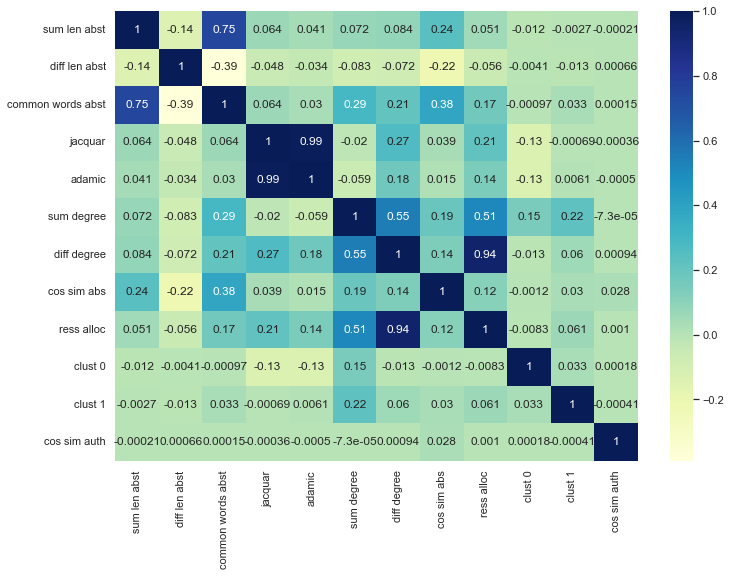

In [6]:
# Visualize the correlation between features using a heatmap
import seaborn as sns

# Set the size of the heatmap
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create a pandas dataframe from the training set feature matrix
X_train_df = pd.DataFrame(X_train, columns =['sum len abst', 'diff len abst', 'common words abst', 'jacquar', 'adamic', 'sum degree', 'diff degree', 'cos sim abs', 'ress alloc', 'clust 0', 'clust 1', 'cos sim auth'])

# Generate a heatmap of the correlations between features
dataplot = sns.heatmap(X_train_df.corr(), cmap="YlGnBu", annot=True)

## Features importance

<AxesSubplot:title={'center':'Feature Importance'}>

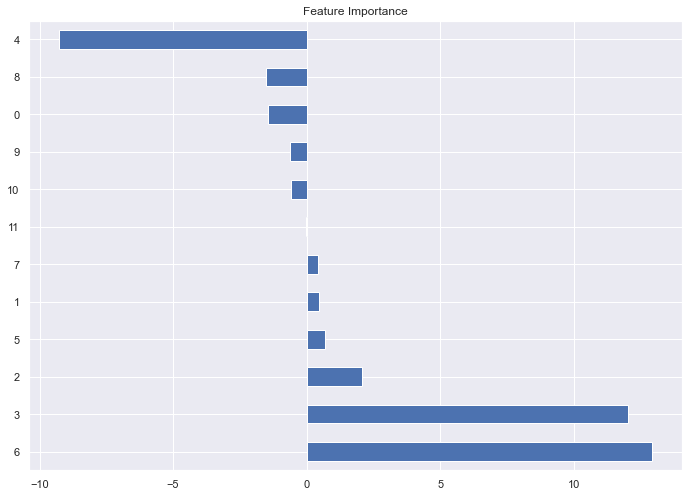

In [9]:
# Logistic regression feature importance
importance = lr_clf.coef_[0]

# Create a pandas series of feature importances
feature_names= ['sum len abst', 'diff len abst', 'common words abst', 'jacquar', 'adamic', 'sum degree', 'diff degree', 'cos sim abs', 'ress alloc', 'clust 0', 'clust 1', 'cos sim auth']
feat_importances = pd.Series(importance)

# Plot the top 20 features by importance
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

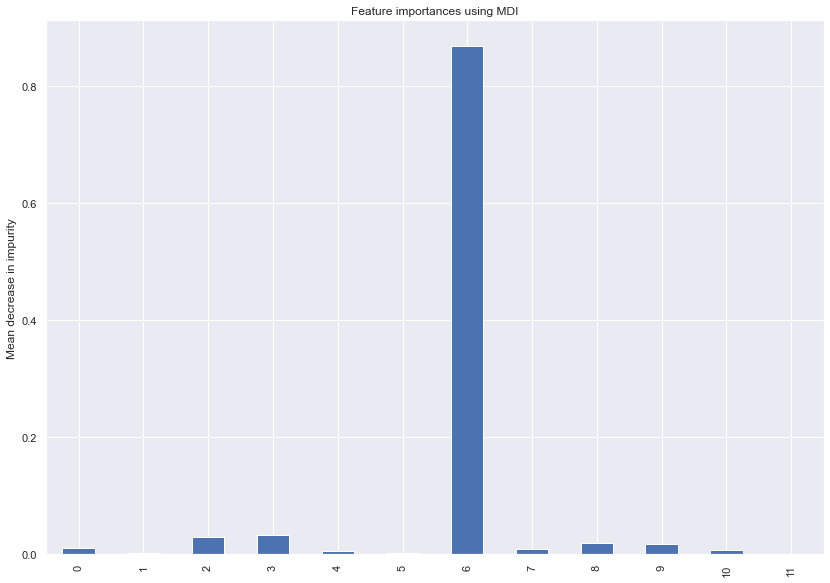

In [13]:
# XgBoost
importances = xgb_clf.feature_importances_
feature_names= ['sum len abst', 'diff len abst', 'common words abst', 'jacquar', 'adamic', 'sum degree', 'diff degree', 'cos sim abs', 'ress alloc', 'clust 0', 'clust 1', 'cos sim auth']

# create a pandas series of feature importances with the feature names as the index
forest_importances = pd.Series(importances, index=feature_names)

# create a bar plot of feature importances using the matplotlib library
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [55]:
# Define a list of feature indices to be deleted
features_to_delete_idx = [
                           #0, # Uncomment and use this line to keep the 'sum len abst' feature
                           1, # Delete the 'diff len abst' feature at index 1
                           #2, # Uncomment and use this line to keep the 'common words abst' feature
                           #3, # Uncomment and use this line to keep the 'jacquar' feature
                           #4, # Uncomment and use this line to keep the 'adamic' feature
                           5, # Delete the 'sum degree' feature at index 5
                           #6, # Uncomment and use this line to keep the 'diff degree' feature
                           #7, # Uncomment and use this line to keep the 'cos sim abs' feature
                           #8, # Uncomment and use this line to keep the 'ress alloc' feature
                           #9, # Uncomment and use this line to keep the 'clust 0' feature
                           #10 # Uncomment and use this line to keep the 'clust 1' feature
                           11 # Delete the 'cos sim auth' feature at index 11
                        ]

# Delete the features with the indices defined above from the training set
X_train_ = np.delete(X_train, features_to_delete_idx, axis=1)

# Delete the features with the indices defined above from the validation set
X_valid_ = np.delete(X_valid, features_to_delete_idx, axis=1)

# Delete the features with the indices defined above from the test set
X_test_ = np.delete(X_test, features_to_delete_idx, axis=1)

## Train and test with selected features

In [56]:
## Logistic regression
# Create an array containing the indices of the features to be deleted
features_to_delete_idx = [1, 5, 11]

# Delete the specified features from the training, validation and test matrices
X_train_ = np.delete(X_train, features_to_delete_idx, axis=1)
X_valid_ = np.delete(X_valid, features_to_delete_idx, axis=1)
X_test_ = np.delete(X_test, features_to_delete_idx, axis=1)

# Train a logistic regression model with the modified training set
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train_, y_train)

# Make predictions on the training set
y_proba_train = lr_clf.predict_proba(X_train_)
y_pred_train = y_proba_train[:,-1]

# Calculate and print the log loss on the training set
print('Log loss on training set:', log_loss(y_train, y_pred_train))

# Make predictions on the validation set
y_proba_valid = lr_clf.predict_proba(X_valid_)
y_pred_valid = y_proba_valid[:,-1]

# Calculate and print the log loss on the validation set
print('Log loss on validation set:', log_loss(y_valid, y_pred_valid))

# Count the number of predictions that are classified as 1 or 0
# when the predicted probability is above 0.5
np.unique(np.where(y_pred_valid>0.5, 1,0), return_counts=True)

Log loss: 0.28282177120337665
Log loss: 0.3146679345522176


(array([0, 1]), array([198322, 150684]))

In [57]:
## XGB
# instantiate the XGBClassifier classifier 
xgb_clf = XGBClassifier(n_jobs=8, use_label_encoder=False)

# fit the classifier to the training data after removing the selected features
xgb_clf.fit(X_train_, y_train)

# predict the probabilities of each class for the training set
y_proba_train = xgb_clf.predict_proba(X_train_)

# predict the probabilities of each class for the validation set
y_proba_valid = xgb_clf.predict_proba(X_valid_)

# get the probabilities of the positive class for both training and validation sets
y_pred_train = y_proba_train[:, 1]
y_pred_valid = y_proba_valid[:, 1]

# calculate and print the log loss for the training set
print('Log loss train:', log_loss(y_train, y_pred_train))

# calculate and print the log loss for the validation set
print('Log loss valid:', log_loss(y_valid, y_pred_valid))

[13:45:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Log loss train: 0.22575310826009595
Log loss valid: 0.3164638049837652


In [59]:
# Set the seed for reproducibility
tf.random.set_seed(42)

# Create a sequential model
model = keras.Sequential()

# Adding layers to the model
model.add(keras.layers.InputLayer(input_shape=[9,])) 
model.add(keras.layers.Dense(128, activation="relu")) 
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Compiling the model with binary crossentropy as the loss function and Adam optimizer
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["binary_accuracy"],
              )

# Training the model for 10 epochs with the training data and validating with the validation data
history = model.fit(X_train_, y_train, epochs=10, validation_data=(X_valid_, y_valid))

Epoch 1/10
43735/43735 [==============================] - 39s 889us/step - loss: 0.2540 - binary_accuracy: 0.8924 - val_loss: 0.2944 - val_binary_accuracy: 0.8798
Epoch 2/10
43735/43735 [==============================] - 38s 876us/step - loss: 0.2451 - binary_accuracy: 0.8956 - val_loss: 0.2918 - val_binary_accuracy: 0.8781
Epoch 3/10
43735/43735 [==============================] - 39s 887us/step - loss: 0.2430 - binary_accuracy: 0.8964 - val_loss: 0.2941 - val_binary_accuracy: 0.8813
Epoch 4/10
43735/43735 [==============================] - 38s 875us/step - loss: 0.2416 - binary_accuracy: 0.8969 - val_loss: 0.2886 - val_binary_accuracy: 0.8818
Epoch 5/10
43735/43735 [==============================] - 39s 891us/step - loss: 0.2408 - binary_accuracy: 0.8971 - val_loss: 0.2843 - val_binary_accuracy: 0.8820
Epoch 6/10
43735/43735 [==============================] - 37s 846us/step - loss: 0.2401 - binary_accuracy: 0.8975 - val_loss: 0.2914 - val_binary_accuracy: 0.8822
Epoch 7/10
43735/43735

In [ ]:
print(classification_report(y_valid, np.where(y_pred_valid>0.5, 1, 0)))

## Gridsearch

In [ ]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"]}  # l1 lasso l2 ridge

# Instantiate a logistic regression classifier
lr_clf = LogisticRegression()

# Perform grid search with cross-validation to find the best hyperparameters
logreg_cv = GridSearchCV(lr_clf, grid, cv=10)
logreg_cv.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Tuned hyperparameters (best parameters): ", logreg_cv.best_params_)
print("Accuracy: ", logreg_cv.best_score_)

# Perspectives

To further enhance our citation prediction model, we can explore additional techniques such as:

- Node2vec: a node embedding algorithm that can help us capture structural information in the citation network and represent each node as a vector.
- Tf-Idf: a text representation technique that can help us extract relevant features from the abstracts of the papers.
- Scibert: a pre-trained language model that can help us extract relevant features from the text data in a more efficient way compared to traditional techniques.

By combining these techniques with the existing methods, we can potentially improve the performance of our model and achieve better prediction accuracy.